In [1]:
from scipy.constants import c
import numpy as np
from numpy.lib import recfunctions as rec
from astropy.io          import fits
from astropy.coordinates import SkyCoord, Angle, search_around_sky
from astropy             import units as u
from astropy import cosmology
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from redmapper import RunZScan
from redmapper import Configuration
from matplotlib import pyplot as plt
import pandas as pd
import math
from tqdm.notebook import tqdm
import pickle
import time
import scipy.optimize as optimize
from iminuit import Minuit

import SciServer
from SciServer import Authentication, LoginPortal, Config, CasJobs, SkyQuery, SciDrive, SkyServer, Files, Jobs

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import matplotlib
from matplotlib import cm

from scipy.stats import norm
from scipy import interpolate
from sklearn.mixture import GaussianMixture

# convert all files matching a glob
import img2pdf
import glob
import re

import emcee
import corner
from scipy.integrate import quad, dblquad

%load_ext cython

# The Plan

We're going to be classifying cluster candidates as belonging either to the population of genuine clusters or to the population of random lines of sight. To do that, we're going to compare the characteristics of a genuine catalog versus a randoms catalog, which we created in the previous notebook.

We're comparing the catalogs in three different spaces:
* Redshift
* Distance of the optical match from the location where we believed a cluster would be
* How close the richness is to what we expect for the size of the mass signal

Once the classifier is created, you can then plot any cluster candidate in these spaces and determine if it is likely to be a true cluster. You can also plot multiple potential optical matches in these spaces and give each a value of p_rand, to choose the best match.

In the first section of this notebook, we're going to load in the catalogs and fit their distributions in multiple spaces.

# Load the catalogs

In [2]:
def angular_separation(ra1,dec1,ra2,dec2):
    r1=np.radians(np.array(ra1))
    d1=np.radians(np.array(dec1))
    r2=np.radians(np.array(ra2))
    d2=np.radians(np.array(dec2))
    
    angular_sep=np.arccos(np.sin(d1)*np.sin(d2)+np.cos(d1)*np.cos(d2)*np.cos(r1-r2))
    idx=np.where(np.isnan(angular_sep))[0]
    angular_sep[idx]=0
    
    return angular_sep

In [3]:
all=pd.read_pickle('ACT_withrprior_convradialfilter_withzscanprior_nozlambdalikeprior_withneighborcorrection_bugcorrection3.pkl')
all_noprior=pd.read_pickle('ACT_norprior_convradialfilter_withzscanprior_nozlambdalikeprior_withneighborcorrection_iteration2.pkl')

# Determine which clusters changed as a result of the radial prior

One outstanding question when applying our new prior is, how many clusters does it affect? Here, I separate the catalog into 'different' (those whose centers change with the prior) and 'same' (those that don't).

I also define some useful columns:
* 'deg_err' -- the measurement error in the ACT catalog, in degrees
* 'SZ_angular_sep' -- the angular separation between the center of the mass signal and the optical center
* 'pnop_angular_sep' -- the angular separation between the optical center with and without a prior
* 'D_A' -- the angular diameter distance at the mass signal's proposed redshift (h^-1 Mpc/degee)
* 'with/no prior physical sep' -- the physical separation between the mass signal and the optical center, in Mpc h^-1

In [4]:
all['deg_err'] = (1.483/all.fixed_SNR-0.012)/60#degrees
all_noprior['deg_err'] = (1.483/all_noprior.fixed_SNR-0.012)/60 #degrees

o = pd.DataFrame(columns = all_noprior.columns)
for i in range(len(all_noprior)):
    o=o.append(all[all.index==all_noprior.index[i]])
all=o

o = pd.DataFrame(columns = all.columns)
for i in range(len(all)):
    o=o.append(all_noprior[all_noprior.index==all.index[i]])

all_noprior=o

all['SZ_angular_sep']=angular_separation(all.RADeg,all.decDeg, all.raopt, all.decopt)
all_noprior['SZ_angular_sep']=angular_separation(all_noprior.RADeg,all_noprior.decDeg, all_noprior.raopt, all_noprior.decopt)

all['pnop_angular_sep']=angular_separation(all.raopt, all.decopt, all_noprior.raopt, all_noprior.decopt)
all_noprior['pnop_angular_sep']=angular_separation(all.raopt, all.decopt, all_noprior.raopt, all_noprior.decopt)

COSMO = FlatLambdaCDM(H0=100, Om0=0.3)
angular_diameter_distances = COSMO.angular_diameter_distance(all.zopt).value #Mpc
all['withprior_physical_sep']=all['SZ_angular_sep']*angular_diameter_distances
all['D_A']=COSMO.angular_diameter_distance(all.zopt).value*np.radians(1.) #Mpc/degree

COSMO = FlatLambdaCDM(H0=100, Om0=0.3)
angular_diameter_distances = COSMO.angular_diameter_distance(all_noprior.zopt).value #Mpc
all_noprior['noprior_physical_sep']=all_noprior['SZ_angular_sep']*angular_diameter_distances
all_noprior['D_A']=COSMO.angular_diameter_distance(all_noprior.zopt).value*np.radians(1.) #Mpc/degree

different=all[all.pnop_angular_sep>1e-5].reset_index(drop=True)
different_noprior=all_noprior[all_noprior.pnop_angular_sep>1e-5].reset_index(drop=True)

names_to_cut = different.name
same=all[~all.name.isin(names_to_cut)]
same_noprior=all_noprior[~all_noprior.name.isin(names_to_cut)]

<ipython-input-2-8e8971527cee>:7: RuntimeWarning: invalid value encountered in arccos
  angular_sep=np.arccos(np.sin(d1)*np.sin(d2)+np.cos(d1)*np.cos(d2)*np.cos(r1-r2))


In [5]:
randoms=pd.read_pickle("newconv_randoms.pkl")

In [6]:
randoms['deg_err'] = (1.483/randoms.fixed_SNR-0.012)/60#degrees
randoms['SZ_angular_sep']=angular_separation(randoms.RADeg,randoms.decDeg, randoms.raopt, randoms.decopt)

COSMO = FlatLambdaCDM(H0=100, Om0=0.3)
angular_diameter_distances = COSMO.angular_diameter_distance(randoms.zopt).value #Mpc
randoms['withprior_physical_sep']=randoms['SZ_angular_sep']*angular_diameter_distances
randoms['D_A']=COSMO.angular_diameter_distance(randoms.zopt).value*np.radians(1.) #Mpc/degree

# Classifier #1: the mass-richness relation

In [7]:
_x = np.array(all.M200m)
_y = np.array(np.log(all.lambdaopt))
_M0 = np.array(np.median(all.M200m))
_expx = np.array(all.M200m)
_z0=np.median(all.zopt)
_z_lambda=np.array(all.zopt)

In [8]:
def log_likelihood(theta):
    global _x, _y, _M0, _expx
    A,alpha,s0,B,beta=theta
    
    model = alpha * np.log(_x/_M0) + A
#    sigma2 = np.repeat(s0,len(_x))
    sigma2 = s0 + B*(_x/_M0)**beta

    N=len(_x)
    if ((sigma2>0).all()):
        return -0.5* np.sum( (_y - model) ** 2 / sigma2) - 0.5*np.sum( np.log(2*np.pi*sigma2+1e-100) )
    else:
        return -np.inf


In [9]:
def nll(theta):
    return -log_likelihood(theta)

In [ ]:
#Optimize deterministically, using minuit

In [10]:
labels=[r'$A$',r'$\alpha$',r'$\sigma_0^2$', r'$B$', r'$\beta$']
nll.errordef=5e-1
nll.name=labels
mm = Minuit(nll, (5,1,1,0,1), name=labels)
mm.limits = [(0, 10), (0, 5),(0,10), (-5, 5),(-7,5)]
mm.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 913.8                      │              Nfcn = 665              │
│ EDM = 5.23e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $A$          │   3.781   │   0.017   │            │            │    0    │   10    │       │
│ 1 │ $\alpha$     │   0.87    │   0.04    │            │            │    0    │    5    │       │
│ 2 │ $\sigma_0^2$ │    0.0    │    1.3    │            │            │    0    │   10    │       │
│ 3 │ $B$          │   0.31    │   0.13    │            │            │   -5    │    5    │       │
│ 4 │ $\beta$      │   -0.9    │    0.6    │            │            │   -7    │    5    │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │          $A$     $\alpha$ $\sigma_0^2$          $B$      $\beta$ │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│          $A$ │     0.000298    -0.000286    -0.000158      0.00017     0.000625 │
│     $\alpha$ │    -0.000286      0.00172      0.00234      -0.0025      -0.0103 │
│ $\sigma_0^2$ │    -0.000158      0.00234       0.0141       -0.015      -0.0651 │
│          $B$ │      0.00017      -0.0025       -0.015       0.0161        0.069 │
│      $\beta$ │     0.000625      -0.0103      -0.0651        0.069        0.316 │
└──────────────┴──────────────────────────────────────────────────────────────────┘

In [20]:
#Check optimization with MCMC

In [11]:
origin=np.array(mm.values)
delta=np.array(mm.errors)

In [12]:
#Parameters that Paxton's mcmc is initialized with
ndim, nwalkers = 5,40
pos = [origin + delta*np.random.randn(ndim) for i in range(nwalkers)]
#Now I set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)

In [13]:
sampler.run_mcmc(pos, 4000, progress=True); #run a 1000 length chain starting at pos

  0%|          | 0/4000 [00:00<?, ?it/s]/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 4000/4000 [00:14<00:00, 266.82it/s]


In [14]:
#Getting the values that maximize likelihood
flat_chain = np.concatenate(sampler.chain)
flat_lnprobs = np.concatenate(sampler.lnprobability)
max_prob_idx = np.argmax(flat_lnprobs)
max_prob = flat_lnprobs[max_prob_idx]
#p, lnsigma_p, alpha, beta = flat_chain[max_prob_idx]
mcmc_best=flat_chain[max_prob_idx]
mcmc_best

array([ 3.77913172e+00,  8.66110667e-01,  3.31206119e-03,  3.05605296e-01,
       -9.38009694e-01])

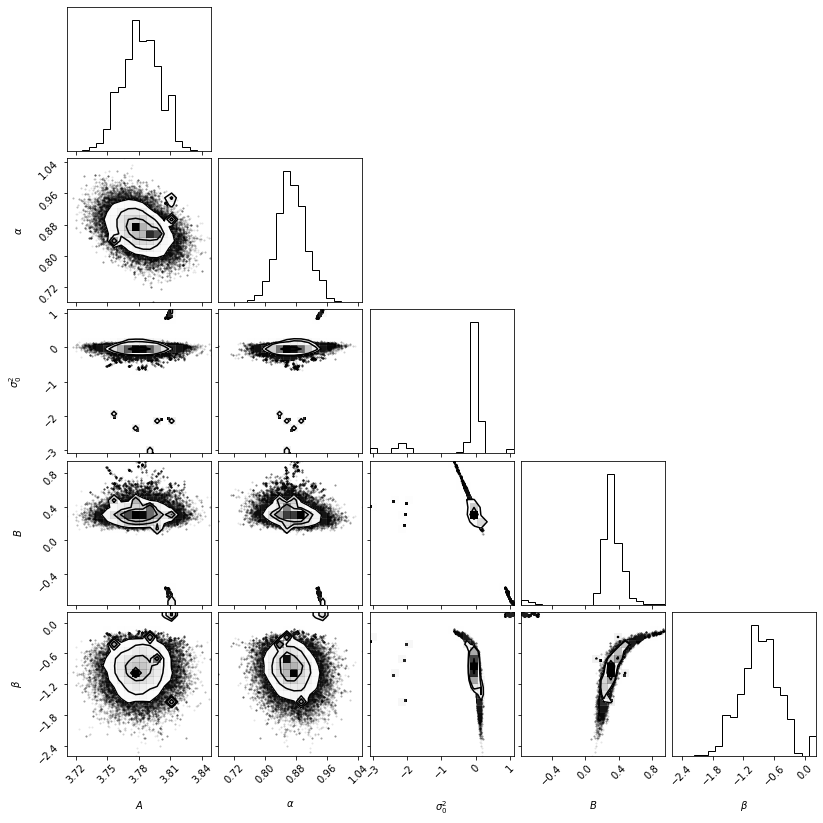

In [15]:
samples = sampler.get_chain(discard=1000, thin=1, flat=False)
samples = samples.reshape((-1, len(origin)))
fig = corner.corner(samples, labels=labels)

In [16]:
flat_samples = sampler.get_chain(discard=1000, thin=1, flat=True)
np.save('neighborcorrection_chain_newconv_iter3.npy', flat_samples) 

In [17]:
chain = np.load("neighborcorrection_chain_newconv_iter3.npy")

draws = np.random.randint(len(chain), size=2000) #the indices to draw
samples= chain[draws].T #should have dimensions of (NDIM, num_draws) so each row is one variable

In [18]:
#Plot the fit

(2, 1000)

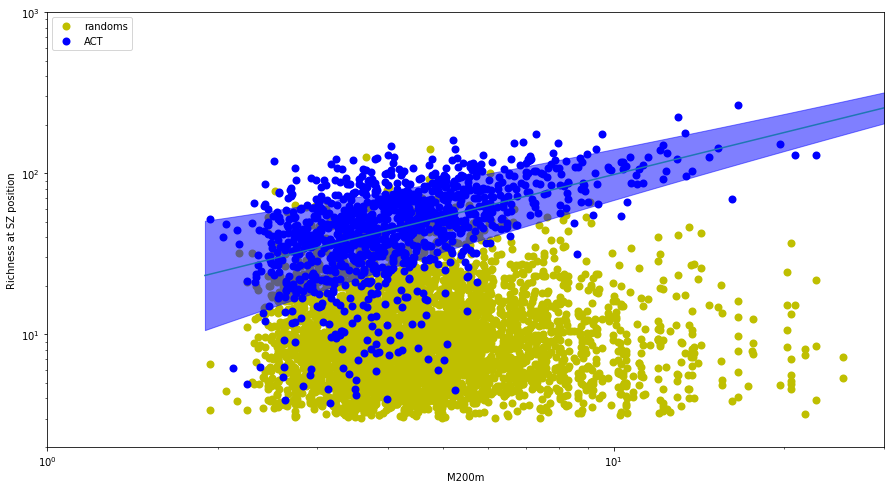

In [19]:
fig,(ax1) = plt.subplots(1, 1,figsize=(15,8))

ax1.scatter(randoms.M200m,randoms.lambda_norecenter,linewidth=2, color='y', label='randoms')
ax1.scatter(all.M200m,all.lambda_norecenter,linewidth=2, color='b', label='ACT')

x=np.logspace(0,2,1000)
x=np.linspace(1.9,30,1000)
A,alpha,s0,B,beta=np.array(mm.values)

model = alpha * np.log(x/_M0) + A
sigma2 = s0 + B*(x/_M0)**beta
y=(model)
ax1.plot(x,np.exp(y))

#sigma2=s0**2
sigma=np.sqrt(sigma2)
ax1.fill_between(x, np.exp(model-sigma), np.exp(model+sigma), color='b', alpha=.5)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Richness at SZ position')
ax1.set_xlabel('M200m')
ax1.legend(loc='upper left')
ax1.set_xlim([1,30])
ax1.set_ylim([2,1000])

# Fit n(M_SZ) and n($\lambda$)

Here I fit the pdfs for mass and richness, which are used to create the classifier. Fits are made by maximizing the log-likelihood. The fitting function is described in the paper.

PS: Here and throughout, I use poor form and declare the data vector 's' as a global. This makes calling the function with various optimizers easier...

In [25]:
from scipy.special import gamma

In [26]:
def llrozo(theta):
    global s
    a,b,M0=theta
    arg1 = -b*(1 - (a+1)/b)
    arg2 = a/b + 1 + 1/b
    norm = M0**b * M0**arg1 * gamma(arg2)/(a+1)
    if ((s**a>0).all()):
        return (np.sum( np.log(s**a) )) - (1/M0)**b*np.sum(s**b) - len(s)*math.log(norm)
    else:
        return -np.inf

def nllrozo(theta):
    return -llrozo(theta)

In [27]:
minM=np.min(all.M200m)
s=np.array(all.M200m-1.9)

In [28]:
labels=[r'a',r'b',r'M0']
nllrozo.errordef=5e-1

m = Minuit(nllrozo, (10,1,1), name=labels)
m.limits = [(0, 15), (0,1),(0,5)]
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1985                       │              Nfcn = 550              │
│ EDM = 0.148 (Goal: 0.0001)       │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   5.15    │   0.28    │            │            │    0    │   15    │       │
│ 1 │ b    │   0.351   │   0.011   │            │            │    0    │    1    │       │
│ 2 │ M0   │  0.63e-3  │  0.28e-3  │            │            │    0    │    5    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────┐
│    │         a         b        M0 │
├────┼───────────────────────────────┤
│  a │    0.0795   -0.0014 -5.22e-05 │
│  b │   -0.0014  0.000121  2.96e-06 │
│ M0 │ -5.22e-05  2.96e-06  7.75e-08 │
└────┴───────────────────────────────┘

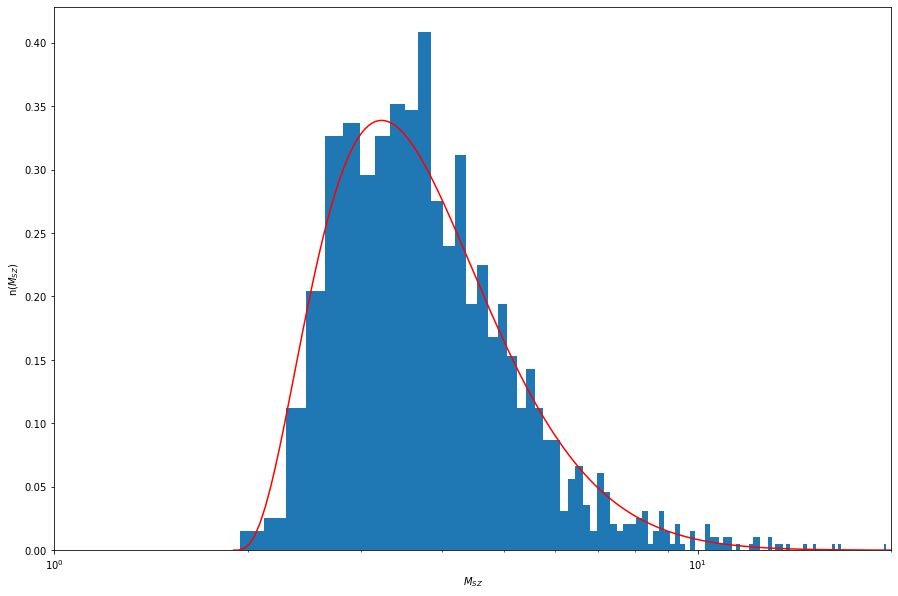

In [29]:
fig,(ax1) = plt.subplots(1, 1,figsize=(15,10))

N=len(all)
minM=np.min(all.M200m)
count,bins=np.histogram(all.M200m,bins=120)
center = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0])
ax1.bar(center,count/N/width,width=width)

x=np.linspace(1.9,40,1000)
a,b,M0=np.array(m.values)
y=(x-1.9)**a*np.exp(-((x-1.9)/M0)**b)
arg1 = -b*(1 - (a+1)/b)
arg2 = a/b + 1 + 1/b
mynorm = M0**b * M0**arg1 * gamma(arg2)/(a+1)
y=y/mynorm
ax1.plot(x,y,color='r')
ax1.set_xlim([1,20])
ax1.set_ylabel('n($M_{SZ}$)')
ax1.set_xlabel('$M_{SZ}$')
ax1.set_xscale('log')

In [30]:
#With the function fit, interpolate it for later use.

In [31]:
from scipy import interpolate
n_MSZ = interpolate.interp1d(x,y)

In [34]:
#Here I begin fitting n(richness). 
#Note that richness is taken at the center of the mass signal, not the matched cluster.

In [35]:
s=np.array(np.log(randoms.lambda_norecenter)-1)

In [36]:
labels=[r'a',r'b',r'lnL0']
nllrozo.errordef=5e-1

m = Minuit(nllrozo, (0.5,1,10), name=labels)
m.limits = [(0, 25), (0,25),(0,50)]
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3825                       │              Nfcn = 217              │
│ EDM = 0.000779 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.38    │   0.14    │            │            │    0    │   25    │       │
│ 1 │ b    │   1.79    │   0.16    │            │            │    0    │   25    │       │
│ 2 │ lnL0 │   1.18    │   0.13    │            │            │    0    │   50    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬─────────────────────────┐
│      │       a       b    lnL0 │
├──────┼─────────────────────────┤
│    a │   0.019  -0.021 -0.0176 │
│    b │  -0.021  0.0263  0.0213 │
│ lnL0 │ -0.0176  0.0213  0.0175 │
└──────┴─────────────────────────┘

Text(0.5, 0, 'ln(Richness at ACT center)')

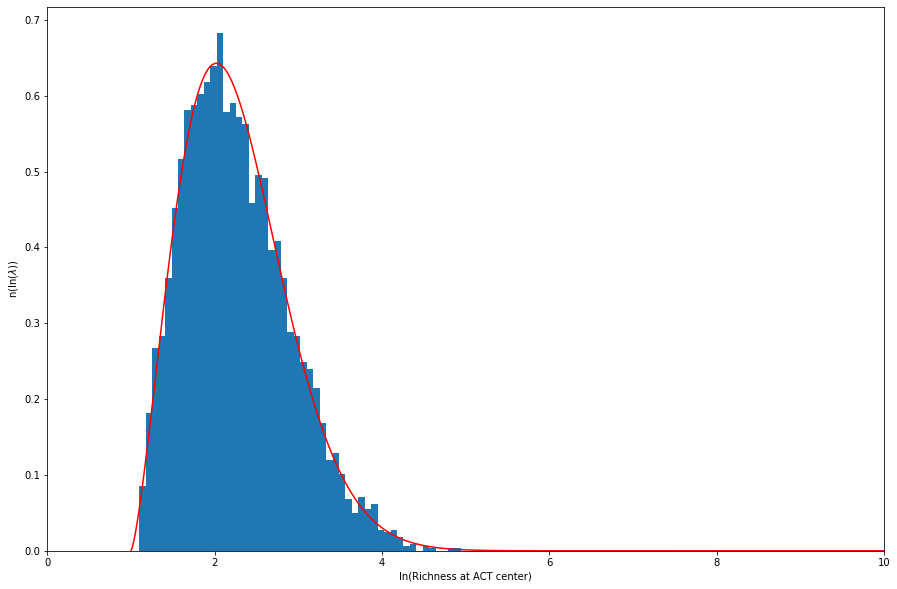

In [37]:
fig,(ax1) = plt.subplots(1, 1,figsize=(15,10))

N=len(randoms)
count,bins=np.histogram(np.log(randoms.lambda_norecenter),bins=50)
center = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0])
ax1.bar(center,count/N/width,width=width)

x=np.linspace(1,10,1000)
a,b,M0=np.array(m.values)
y=(x-1)**a*np.exp(-((x-1)/M0)**b)
arg1 = -b*(1 - (a+1)/b)
arg2 = a/b + 1 + 1/b
norm = M0**b * M0**arg1 * gamma(arg2)/(a+1)
y=y/norm

ax1.plot(x,y,color='r')
ax1.set_xlim([0,10])
ax1.set_ylabel('n(ln($\lambda$))')
ax1.set_xlabel('ln(Richness at ACT center)')

In [38]:
n_lnlambda=interpolate.interp1d(x,y)

In [39]:
#Create the final 'blobs'. I will create a 2d pdf for the ACT clusters, as well as random clusters.

In [40]:
_x = np.array(all.M200m)
_y = np.array(np.log(all.lambdaopt))
_M0 = np.array(np.median(all.M200m))
_expx = np.array(all.M200m)
_z0=np.median(all.zopt)
_z_lambda=np.array(all.zopt)

In [41]:
M_SZ=np.linspace(1.9,30,1000)
lnlambda=np.linspace(1,8,1000)

In [42]:
xv, yv = np.meshgrid(M_SZ, lnlambda)

In [43]:
z=n_MSZ(xv)*n_lnlambda(yv)

In [44]:
from scipy.stats import norm

In [46]:
#This is the 2d pdf for ACT clusters, overlaid with data

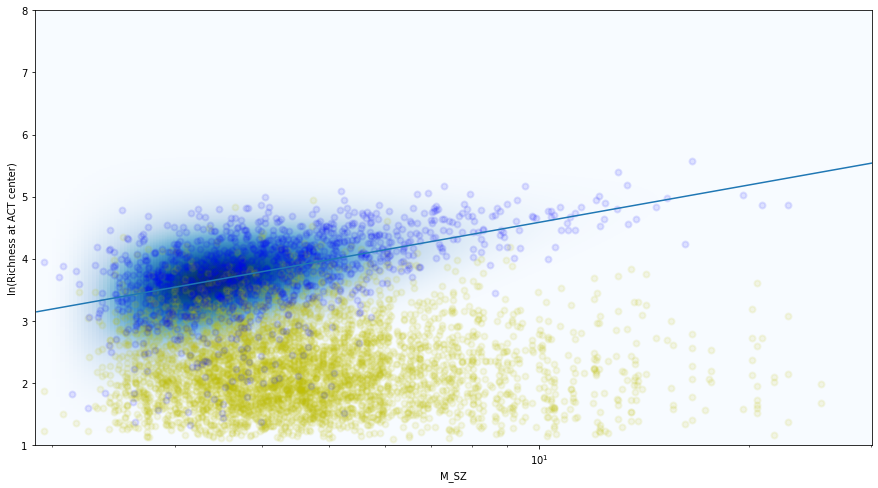

In [47]:
fig,(ax1) = plt.subplots(1, 1,figsize=(15,8))

A,alpha,s0,B,beta=np.array(mm.values)

model = alpha * np.log(M_SZ/_M0) + A
sigma2 = s0 + B*(M_SZ/_M0)**beta
center=model
ax1.plot(M_SZ,model)
#initialize a normal distribution with frozen in mean=-1, std. dev.= 1
rv = norm(loc = center, scale = np.sqrt(sigma2))
spread=rv.pdf(yv)

zz=n_MSZ(xv)*rv.pdf(yv)

h = plt.pcolormesh(xv,yv,zz, cmap='Blues',shading='auto')

#ax1.fill_between(M_SZ, (model-sigma), (model+sigma), color='b', alpha=.5)

ax1.scatter(randoms.M200m,np.log(randoms.lambda_norecenter),linewidth=2, color='y', label='randoms',alpha=0.1)
ax1.scatter(all.M200m,np.log(all.lambda_norecenter),linewidth=2, color='b', label='ACT',alpha=0.1)
ax1.set_xlabel('M_SZ')
ax1.set_ylabel('ln(Richness at ACT center)')
ax1.set_xscale('log')

In [48]:
#This is the 2d pdf of randoms, overlaid with data

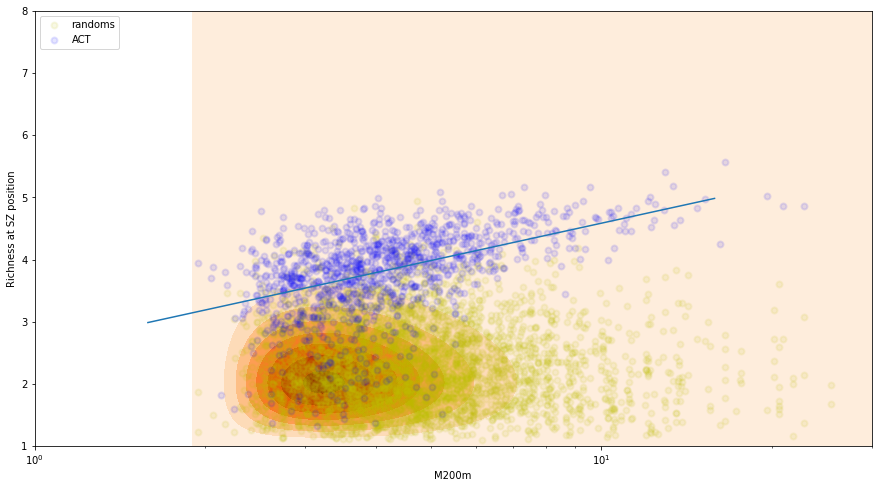

In [49]:
fig,(ax1) = plt.subplots(1, 1,figsize=(15,8))

h = plt.contourf(xv,yv,z, cmap='Oranges')
#h = plt.contourf(xv,yv,zz, cmap='Blues',alpha=0.3)

ax1.scatter(randoms.M200m,np.log(randoms.lambda_norecenter),linewidth=2, color='y', label='randoms',alpha=0.1)
ax1.scatter(all.M200m,np.log(all.lambda_norecenter),linewidth=2, color='b', label='ACT',alpha=0.1)

x=np.logspace(0.2,1.2,1000)

A,alpha,s0,B,beta=np.array(mm.values)

model = alpha * np.log(x/_M0) + A
sigma2 = s0 + B*(x/_M0)**beta
y=(model)
ax1.plot(x,y)

ax1.set_xscale('log')
ax1.set_xlim([1,30])
ax1.set_ylabel('Richness at SZ position')
ax1.set_xlabel('M200m')
ax1.legend(loc='upper left')

In [50]:
#This is a comparison of the two 2d pdfs

<ipython-input-51-6cece21f1795>:3: UserWarning: The following kwargs were not used by contour: 'label'
  h = plt.contourf(xv,yv,z, cmap='Oranges',alpha=0.5,label='Randoms')
<ipython-input-51-6cece21f1795>:4: UserWarning: The following kwargs were not used by contour: 'shading', 'label'
  h = plt.contourf(xv,yv,zz, cmap='Blues',shading='auto',alpha=0.5,label='ACT')


Text(0.5, 0, 'M200m')

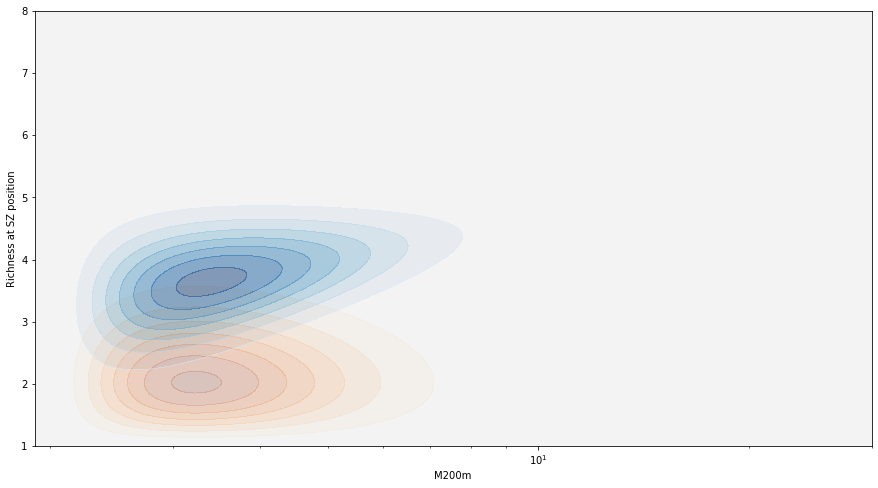

In [51]:
fig,(ax1) = plt.subplots(1, 1,figsize=(15,8))

h = plt.contourf(xv,yv,z, cmap='Oranges',alpha=0.5,label='Randoms')
h = plt.contourf(xv,yv,zz, cmap='Blues',shading='auto',alpha=0.5,label='ACT')

ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_ylabel('Richness at SZ position')
ax1.set_xlabel('M200m')

# Here I declare an important fraction

The randoms pdf is actually much lower than we've calculated heretofore. We need to take into account that most of the randoms did not get matched to an optical cluster at all, and renormalize the randoms pdf. This fraction is responsible for that.

In [52]:
fr=100000/len(randoms)

In [55]:
#Plot the classifier, overlaid with data and the mean of the mass-richness relation.

<ipython-input-56-66e58e23d974>:3: RuntimeWarning: invalid value encountered in true_divide
  odds_M=(z/fr)/(zz+1e-1000)
<ipython-input-56-66e58e23d974>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = plt.pcolormesh(xv,yv,prob_M,label='Randoms',cmap='Greys')


Text(0.5, 0, 'M200m')

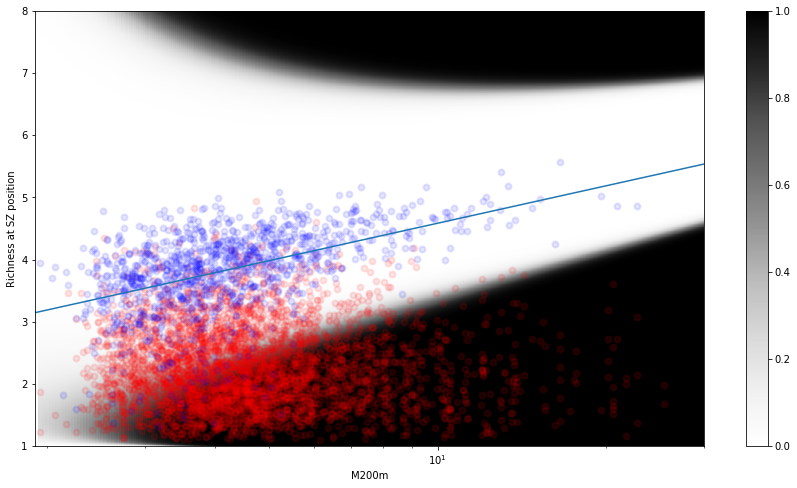

In [56]:
fig,(ax1) = plt.subplots(1, 1,figsize=(15,8))

odds_M=(z/fr)/(zz+1e-1000)
prob_M=odds_M/(odds_M+1)

h = plt.pcolormesh(xv,yv,prob_M,label='Randoms',cmap='Greys')

ax1.scatter(randoms.M200m,np.log(randoms.lambda_norecenter),linewidth=2, color='r', label='randoms',alpha=0.1)
ax1.scatter(all.M200m,np.log(all.lambda_norecenter),linewidth=2, color='b', label='ACT',alpha=0.1)

x=np.linspace(1.9,30,1000)

A,alpha,s0,B,beta=np.array(mm.values)

model = alpha * np.log(x/_M0) + A
sigma2 = s0 + B*(x/_M0)**beta
y=(model)
ax1.plot(x,y)

fig.colorbar(h, ax=ax1)

ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_ylabel('Richness at SZ position')
ax1.set_xlabel('M200m')

In [57]:
#Our work is done! Interpolate the classifier for later use.

In [58]:
p_M_lnSZ = interpolate.interp2d(M_SZ, lnlambda, prob_M)

In [59]:
all_pdf_M_lnSZ = interpolate.interp2d(M_SZ, lnlambda, zz)
randoms_pdf_M_lnSZ = interpolate.interp2d(M_SZ, lnlambda, z/fr)

# Classifier #2, distance

In [64]:
randoms['SZ_angular_sep']=angular_separation(randoms.RADeg,randoms.decDeg, randoms.raopt, randoms.decopt)
COSMO = FlatLambdaCDM(H0=100, Om0=0.3)
randoms['D_A']=COSMO.angular_diameter_distance(randoms.zopt).value*np.radians(1.) #Mpc/degree
randoms['deg_err'] = (1.483/randoms.fixed_SNR-0.012)/60 #degrees

In [75]:
#In the lines below, I create a function \psi_cen. 

#This is a convolution of the measurement error of the position of the cluster, and a gas/optical offset 
#due to a cluster's merger history.

#It is coded as a c-callable integrand for speed.

#See the paper for more details.

In [76]:
from scipy.special import gamma

In [77]:
%%cython 

from cpython.pycapsule cimport (PyCapsule_New,
                                PyCapsule_GetPointer)
from cpython.mem cimport PyMem_Malloc,  PyMem_Free
from libc.math cimport exp, sqrt, M_PI, log,cos, atan, atanh
from libc.math cimport tgamma
import scipy

cdef double c_dblintegrand(int n, double* xx, void* user_data):
    """The integrand, written in Cython"""
    # Extract a.
    # Cython uses array access syntax for pointer dereferencing!
    cdef double alpha = (<double*>user_data)[0]
    cdef double beta = (<double*>user_data)[1]
    cdef double sigma2 = (<double*>user_data)[2]
    cdef double R = (<double*>user_data)[3]
    
    r_prime=xx[1]
    theta_prime=xx[0]
    
    F = beta**alpha/tgamma(alpha)*r_prime**(alpha-1)*exp(-beta*r_prime)

#    F = exp(-(r_prime)**2/2/sigma1**2)
    
    r_dbl_prime=sqrt(r_prime**2+R**2-2*R*r_prime*cos(theta_prime))
    
    G = exp(-(r_dbl_prime)**2/2/sigma2**2)/sigma2**2
    
    return F*G
#
# Now comes some classic C-style housekeeping
#

cdef object pack_a(double alpha, double beta, double sigma2, double R):
    """Wrap 'a' in a PyCapsule for transport."""
    # Allocate memory where 'a' will be saved for the time being
    cdef double* a_ptr = <double*> PyMem_Malloc(4*sizeof(double))
    a_ptr[0] = alpha
    a_ptr[1] = beta
    a_ptr[2] = sigma2
    a_ptr[3] = R
    return PyCapsule_New(<void*>a_ptr, NULL, free_a)

cdef void free_a(capsule):
    """Free the memory our value is using up."""
    PyMem_Free(PyCapsule_GetPointer(capsule, NULL))
    
def get_low_level_callable(double alpha, double beta, double sigma2, double R):
    # scipy.LowLevelCallable expects the function signature to
    # appear as the "name" of the capsule
    func_capsule = PyCapsule_New(<void*>c_dblintegrand,
                                 "double (int, double *, void *)",
                                 NULL)
    data_capsule = pack_a(alpha,beta,sigma2,R)
    
    return scipy.LowLevelCallable(func_capsule, data_capsule)

In [ ]:
#Here, define a function gamma_convolved_with_err which gives the distribution of offsets.
#Inputs alpha and beta characterize the gas offset.
#Sigma is the measurement error in h^-1 Mpc
#R is the magnitude of the 2d distance from the cluster signal.

In [78]:
def dblgamma_c(alpha,beta,sigma2,R,eps):
    c_integrand = get_low_level_callable(alpha,beta,sigma2,R)
    y, abserr = dblquad(c_integrand, 0,np.inf,0,2*np.pi,epsabs=eps)
    return y

@np.vectorize
def gamma_convolved_with_err(alpha, beta, sigma, R):
    return dblgamma_c(alpha,beta,sigma,R,eps=1.49e-30)*R/2/np.pi

def gamma_dist(alpha, beta, R):
    return np.array(beta**alpha/gamma(alpha)*R**(alpha-1)*np.exp(-beta*R))

In [80]:
#This is the likelihood function we will use to optimize the shape of the gas offset distribution.

In [81]:
def llgamma(theta):
    global s
    global i
    global sigma
    beta,alpha=theta
    i=i+1
    print(i)
    norm = beta**alpha/gamma(alpha)
    if ((alpha>0) and (beta>0)):
#        ll = np.abs(np.sum( np.log(s**(alpha-1)) )) - beta*np.sum(np.abs(s)) + len(s)*math.log(norm)
        ll = np.sum(np.log(gamma_convolved_with_err(alpha,beta,sigma,s)))
        return ll
    else:
        return -np.inf

In [82]:
def nllgamma(theta):
    return -llgamma(theta)

In [83]:
s=all.withprior_physical_sep
sigma=all['deg_err']*all['D_A']

i=0
labels=[r'$\beta$',r'$\alpha$']
nllgamma.errordef=5e-1
m = Minuit(nllgamma, (11,2),name=labels)
m.limits=[(0,50),(0,10)]
m.migrad()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1366                      │              Nfcn = 47               │
│ EDM = 5.32e-06 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $\beta$  │    7.9    │    0.7    │            │            │    0    │   50    │       │
│ 1 │ $\alpha$ │   0.72    │   0.06    │            │            │    0    │   10    │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────┐
│          │  $\beta$ $\alpha$ │
├──────────┼───────────────────┤
│  $\beta$ │    0.437   0.0367 │
│ $\alpha$ │   0.0367  0.00394 │
└──────────┴───────────────────┘

In [84]:
#Now we make some definitions for plotting.

#This is the Welford algorithm. It is used to calculate a running estimate of mean and variance each time
#a new sample is taken. See Knuth.

In [85]:
import math

class RunningStats:

    def __init__(self):
        self.n = 0
        self.old_m = 0
        self.new_m = 0
        self.old_s = 0
        self.new_s = 0

    def clear(self):
        self.n = 0
    
    def push(self, x):
        self.n += 1
    
        if self.n == 1:
            self.old_m = self.new_m = x
            self.old_s = 0
        else:
            self.new_m = self.old_m + (x - self.old_m) / self.n
            self.new_s = self.old_s + (x - self.old_m) * (x - self.new_m)
        
            self.old_m = self.new_m
            self.old_s = self.new_s

    def mean(self):
        return self.new_m if self.n else 0.0

    def variance(self):
        return self.new_s / (self.n - 1) if self.n > 1 else 0.0
    
    def standard_deviation(self):
        return np.sqrt(self.variance())

In [86]:
mybins=np.linspace(0,2.0,500)
mycenter = (mybins[:-1] + mybins[1:]) / 2

In [87]:
#Here, I produce the mean and std of my fit.

#First, I make a random draw of distance from the distribution of measurement error.
#Next, I make a random draw from the distribution of gas offsets--using the parameters I just fit.
#Finally, I measure the total distance.
#I do this Nrepeat times, updating the mean and std of R_tot each time
#Now I can plot the mean and std

In [88]:
rs=RunningStats()
Nrepeat=50000

for i in tqdm(range(Nrepeat)):
    sigma_R=all.deg_err*all.D_A #Mpc
    R_measurement=np.random.rayleigh(sigma_R)
    #R_measurement=np.random.normal(np.zeros(len(sigma_R)), sigma_R)
    alpha=np.array(m.values)[1]
    beta=np.array(m.values)[0]
    shape, scale = alpha, 1/beta  # mean=4, std=2*sqrt(2)
    R_off = np.random.gamma(shape, scale, len(R_measurement))

    theta=2*np.pi*np.random.rand(len(R_measurement))
    R_tot=np.sqrt(R_off**2+R_measurement**2-2*R_off*R_measurement*np.cos(theta))

    N=len(R_tot)
    count,bins=np.histogram(R_tot,bins=mybins)
    width = (bins[1] - bins[0])
    rs.push(count/N/width)

mymean=rs.mean()
mystd=rs.standard_deviation()

  0%|          | 0/50000 [00:00<?, ?it/s]

In [89]:
#Plot the central filter, psi_cen

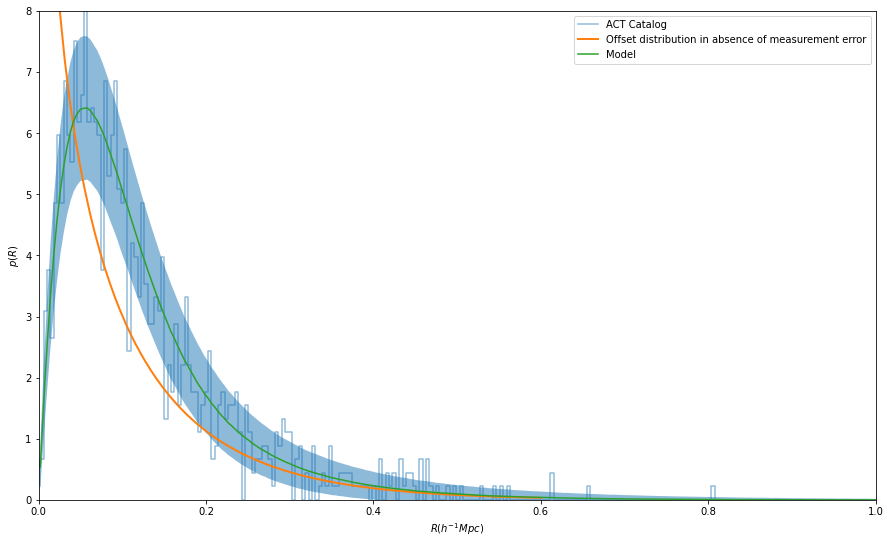

In [90]:
fig,(ax2) = plt.subplots(1, 1,figsize=(15,9))

#N=len(different)
#count,bins=np.histogram(different['SZ_angular_sep']/np.radians(1.)*different['D_A'],bins=40)
#center = (bins[:-1] + bins[1:]) / 2
#width = (bins[1] - bins[0])
#ax2.step(center,count/N/width, alpha=0.5,label='Center did change')

N=len(all)
count,bins=np.histogram(all['withprior_physical_sep'],bins=mybins)
center = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0])
ax2.step(center,count/N/width,alpha=0.5,label='ACT Catalog')

N=len(different)
count,bins=np.histogram(different['withprior_physical_sep'],bins=40)
center = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0])
#ax2.step(center,count/N/width, alpha=0.5,label='Center did change')

N=len(same)
count,bins=np.histogram(same['withprior_physical_sep'],bins=40)
center = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0])
#ax2.step(center,count/N/width, alpha=0.5,label='Center did change')

x=np.linspace(0.001,.6,100)
alpha=np.array(m.values)[1]
beta=np.array(m.values)[0]
gammafunc = beta**alpha/gamma(alpha)*x**(alpha-1)*np.exp(-beta*x)
ax2.plot(x, gammafunc,linewidth=2, label='Offset distribution in absence of measurement error')
ax2.plot(mycenter, mymean, label='Model')

bottom=mymean-mystd
top=mymean+mystd
ax2.fill_between(mycenter,bottom,top,alpha=0.5)
ax2.set_xlabel(r'$R (h^{-1} Mpc)$')
ax2.set_ylabel(r'$p(R)$')
ax2.set_ylim([0,8])
ax2.set_xlim([0,1.0])
ax2.legend()

In [91]:
#Follow the same procedure for the randoms catalog

In [92]:
s=randoms['withprior_physical_sep']
sigma=randoms['deg_err']*randoms['D_A']

i=0
labels=[r'$\beta$',r'$\alpha$']
nllgamma.errordef=5e-1
n = Minuit(nllgamma, (13,3),name=labels)
n.limits=[(0,50),(0,10)]
n.migrad()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -2509                      │              Nfcn = 39               │
│ EDM = 7.56e-08 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $\beta$  │   13.2    │    0.4    │            │            │    0    │   50    │       │
│ 1 │ $\alpha$ │   3.35    │   0.10    │            │            │    0    │   10    │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────┐
│          │  $\beta$ $\alpha$ │
├──────────┼───────────────────┤
│  $\beta$ │    0.149   0.0353 │
│ $\alpha$ │   0.0353  0.00927 │
└──────────┴───────────────────┘

In [93]:
mybins=np.linspace(0,2.0,500)
mycenter = (mybins[:-1] + mybins[1:]) / 2

In [95]:
rs=RunningStats()
Nrepeat=50000

for i in range(Nrepeat):
    sigma_R=randoms.deg_err*randoms.D_A #Mpc
    R_measurement=np.random.rayleigh(sigma_R)
    #R_measurement=np.random.normal(np.zeros(len(sigma_R)), sigma_R)
    alpha=np.array(n.values)[1]
    beta=np.array(n.values)[0]
#    alpha=2.248
#    beta=8.5
    shape, scale = alpha, 1/beta  # mean=4, std=2*sqrt(2)
    R_off = np.random.gamma(shape, scale, len(R_measurement))

    theta=2*np.pi*np.random.rand(len(R_measurement))
    R_tot=np.sqrt(R_off**2+R_measurement**2-2*R_off*R_measurement*np.cos(theta))

    N=len(R_tot)
    count,bins=np.histogram(R_tot,bins=mybins)
    width = (bins[1] - bins[0])
    rs.push(count/N/width)

randmean=rs.mean()
randstd=rs.standard_deviation()

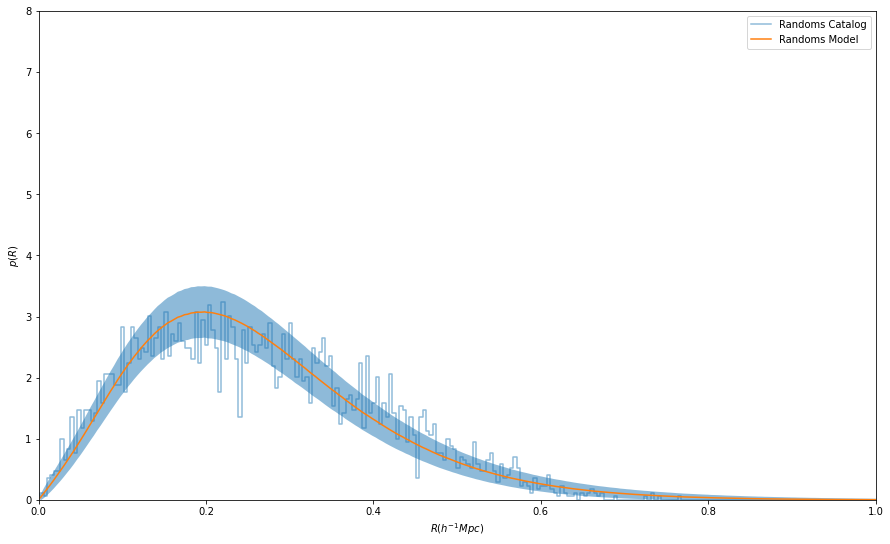

In [96]:
fig,(ax2) = plt.subplots(1, 1,figsize=(15,9))

#N=len(different)
#count,bins=np.histogram(different['SZ_angular_sep']/np.radians(1.)*different['D_A'],bins=40)
#center = (bins[:-1] + bins[1:]) / 2
#width = (bins[1] - bins[0])
#ax2.step(center,count/N/width, alpha=0.5,label='Center did change')

N=len(randoms)
count,bins=np.histogram(randoms['withprior_physical_sep'],bins=mybins)
center = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0])
ax2.step(center,count/N/width,alpha=0.5,label='Randoms Catalog')

x=np.linspace(0.001,.8,100)
alpha=np.array(n.values)[1]
beta=np.array(n.values)[0]
randgammafunc = beta**alpha/gamma(alpha)*x**(alpha-1)*np.exp(-beta*x)
#ax2.plot(x, gammafunc,linewidth=2, label='Offset distribution in absence of measurement error')
ax2.plot(mycenter, randmean, label='Randoms Model')

bottom=randmean-randstd
top=randmean+randstd
ax2.fill_between(mycenter,bottom,top,alpha=0.5)

ax2.set_xlabel(r'$R (h^{-1} Mpc)$')
ax2.set_ylabel(r'$p(R)$')
ax2.set_ylim([0,8])
ax2.set_xlim([0,1.0])
ax2.legend()

In [97]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 26

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [98]:
from scipy.ndimage import gaussian_filter1d

<ipython-input-99-92d07367d616>:48: RuntimeWarning: divide by zero encountered in true_divide
  odds_sigma=randoms_pdf_sigma/all_pdf_sigma
<ipython-input-99-92d07367d616>:48: RuntimeWarning: invalid value encountered in true_divide
  odds_sigma=randoms_pdf_sigma/all_pdf_sigma
<ipython-input-99-92d07367d616>:49: RuntimeWarning: invalid value encountered in true_divide
  prob_sigma=odds_sigma/(odds_sigma+1)


(0.0, 0.9)

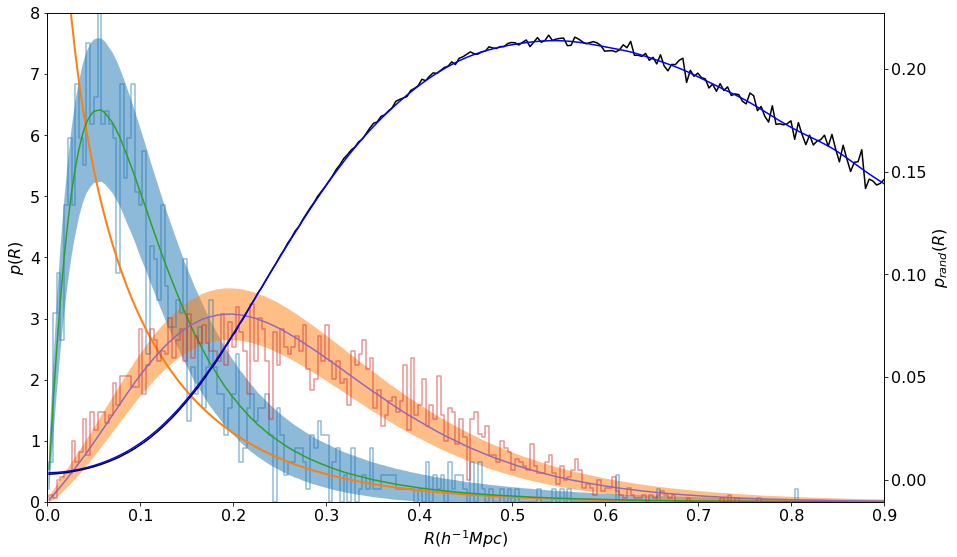

In [99]:
fig,(ax2) = plt.subplots(1, 1,figsize=(15,9))

#N=len(different)
#count,bins=np.histogram(different['SZ_angular_sep']/np.radians(1.)*different['D_A'],bins=40)
#center = (bins[:-1] + bins[1:]) / 2
#width = (bins[1] - bins[0])
#ax2.step(center,count/N/width, alpha=0.5,label='Center did change')

N=len(all)
count,bins=np.histogram(all['withprior_physical_sep'],bins=mybins)
center = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0])
ax2.step(center,count/N/width,alpha=0.5,label='ACT Catalog')

x=mycenter
alpha=np.array(m.values)[1]
beta=np.array(m.values)[0]
gammafunc = beta**alpha/gamma(alpha)*x**(alpha-1)*np.exp(-beta*x)
ax2.plot(x, gammafunc,linewidth=2, label='Offset distribution in absence of measurement error')
ax2.plot(mycenter, mymean, label='Model')

bottom=mymean-mystd
top=mymean+mystd
ax2.fill_between(mycenter,bottom,top,alpha=0.5)

N=len(randoms)
count,bins=np.histogram(randoms['withprior_physical_sep'],bins=mybins)
center = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0])
ax2.step(center,count/N/width,alpha=0.5,label='Randoms Catalog')

x=mycenter
alpha=np.array(n.values)[1]
beta=np.array(n.values)[0]

randgammafunc = beta**alpha/gamma(alpha)*x**(alpha-1)*np.exp(-beta*x)
#ax2.plot(x, gammafunc,linewidth=2, label='Offset distribution in absence of measurement error')
ax2.plot(mycenter, randmean, label='Randoms Model')

bottom=randmean-randstd
top=randmean+randstd
ax2.fill_between(mycenter,bottom,top,alpha=0.5)

switch=500
randoms_pdf_sigma=np.append(randmean[:switch],randgammafunc[switch:])/fr
all_pdf_sigma=np.append(mymean[:switch],gammafunc[switch:])

odds_sigma=randoms_pdf_sigma/all_pdf_sigma
prob_sigma=odds_sigma/(odds_sigma+1)

# Adding Twin Axes to plot using dataset_2
ax9 = ax2.twinx()
ax9.plot(mycenter,prob_sigma, color='k', label='Separation Classifier')
switch=300
randoms_pdf_sigma=np.append(randmean[:switch],randgammafunc[switch:])/fr
all_pdf_sigma=np.append(mymean[:switch],gammafunc[switch:])

odds_sigma=randoms_pdf_sigma/all_pdf_sigma
prob_sigma=odds_sigma/(odds_sigma+1)

mask = np.isnan(prob_sigma)
prob_sigma[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), prob_sigma[~mask])

prob_smooth = gaussian_filter1d(prob_sigma, sigma=5)
ax9.plot(mycenter,prob_smooth, color='b', label='Separation Classifier')

ax9.set_ylabel('$p_{rand}(R)$')

#ax1.hist(same['SZ_angular_sep']/np.radians(1.)/deg_err,30,label='With Prior')
#ax1.hist(same_noprior['SZ_angular_sep']/np.radians(1.)/deg_err,30,alpha=0.5, label='No Prior')

ax2.set_xlabel(r'$R (h^{-1} Mpc)$')
ax2.set_ylabel(r'$p(R)$')
ax2.set_ylim([0,8])
ax2.set_xlim([0,0.9])
#ax2.legend()

# Classifier #3: Redshift

In [100]:
from scipy.stats import t, norm

In [121]:
tofit=np.array((all.zopt-all.redshift)/all.redshiftErr)
tofit=tofit[np.abs(tofit)<3.0]

<ipython-input-122-ab8c53126489>:86: RuntimeWarning: divide by zero encountered in true_divide
  odds_sigma=randoms_pdf_sigma/all_pdf_sigma
<ipython-input-122-ab8c53126489>:86: RuntimeWarning: invalid value encountered in true_divide
  odds_sigma=randoms_pdf_sigma/all_pdf_sigma
<ipython-input-122-ab8c53126489>:87: RuntimeWarning: invalid value encountered in true_divide
  prob_sigma=odds_sigma/(odds_sigma+1)


(0.0, 0.8)

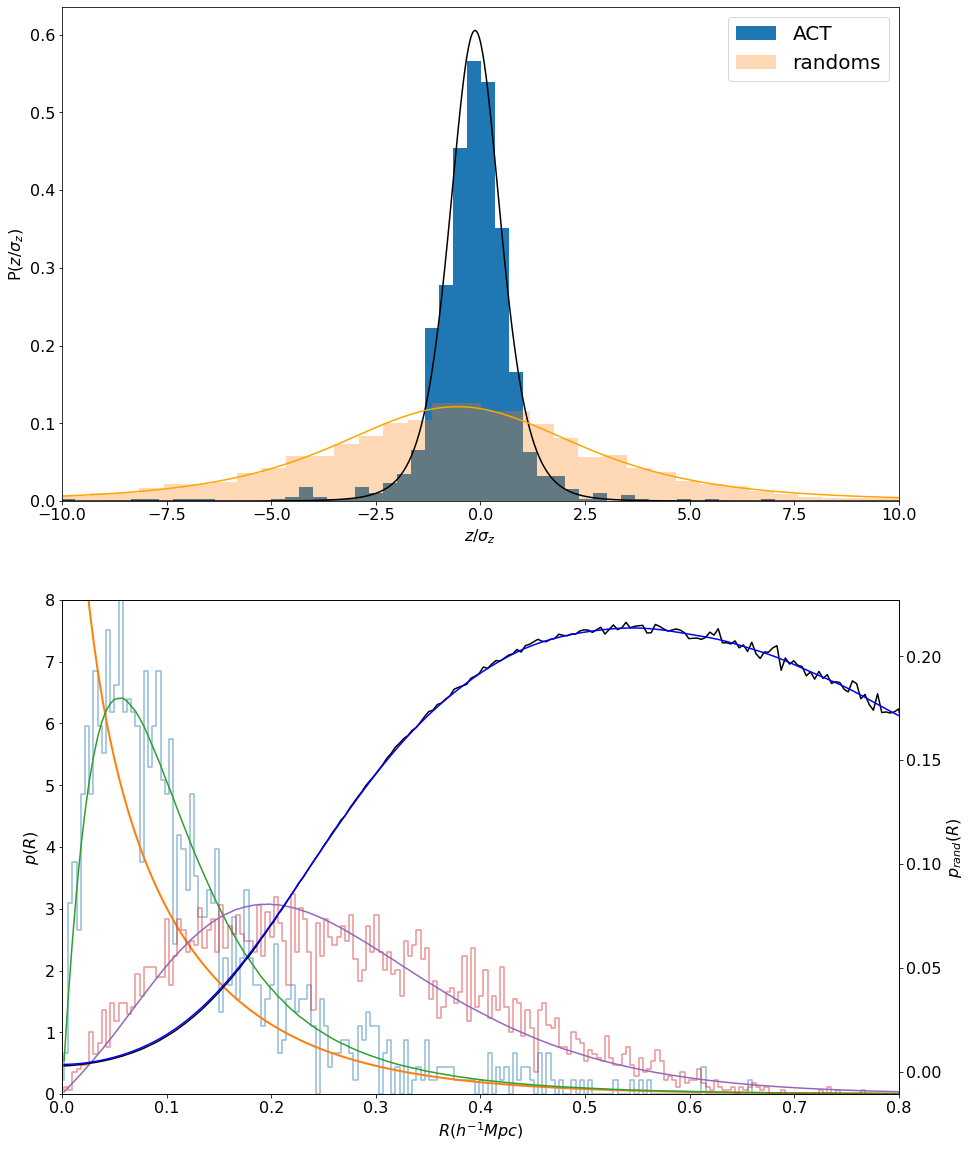

In [122]:
fig,(ax1,ax2) = plt.subplots(2, 1,figsize=(15,20))

N=len(all)
deg_err = (1.483/all.fixed_SNR-0.012)/60
count,bins=np.histogram((all.zopt-all.redshift)/all.redshiftErr,bins=100)
center = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0])
ax1.bar(center,count/N/width,width=width,label='ACT')

Nmix=1

x = np.linspace(-10, 10, 1000)
#mu=all_mu
#sigma=all_sigma
#pdf=1/np.sqrt(2*np.pi*sigma**2)*np.exp(-0.5*(x-mu)**2/sigma**2)

#ax1.plot(x,pdf, color='orange')
samp = (all.zopt-all.redshift)/all.redshiftErr
allparam = t.fit(tofit)

pdf_fitted = t.pdf(x, loc=allparam[1], scale=allparam[2], df=allparam[0])
#pdf_fitted = norm.pdf(x, loc=allmean, scale=allcov)
ax1.plot(x,pdf_fitted, color='k')
#ax1.plot(x,pdf, color='k')

N=len(randoms)
deg_err = (1.483/randoms.fixed_SNR-0.012)/60
count,bins=np.histogram((randoms.zopt-randoms.redshift)/randoms.redshiftErr,bins=100)
center = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0])
ax1.bar(center,count/N/width,width=width,alpha=0.3,label='randoms')

#ax1.plot(x,pdf, color='orange')
samp = (randoms.zopt-randoms.redshift)/randoms.redshiftErr
param = t.fit(samp)

pdf_fitted = t.pdf(x, loc=param[1], scale=param[2], df=param[0])
ax1.plot(x,pdf_fitted, color='orange')

#ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_ylabel(r'P($z/\sigma_z$)')
ax1.set_xlabel(r'$z/\sigma_z$')
ax1.legend()
ax1.set_xlim([-10,10])

N=len(all)
count,bins=np.histogram(all['withprior_physical_sep'],bins=mybins)
center = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0])
ax2.step(center,count/N/width,alpha=0.5,label='ACT Catalog')

x=mycenter
alpha=np.array(m.values)[1]
beta=np.array(m.values)[0]
gammafunc = beta**alpha/gamma(alpha)*x**(alpha-1)*np.exp(-beta*x)
ax2.plot(x, gammafunc,linewidth=2, label='Offset distribution in absence of measurement error')
ax2.plot(mycenter, mymean, label='Model')

bottom=mymean-mystd
top=mymean+mystd
#ax2.fill_between(mycenter,bottom,top,alpha=0.5)

N=len(randoms)
count,bins=np.histogram(randoms['withprior_physical_sep'],bins=mybins)
center = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0])
ax2.step(center,count/N/width,alpha=0.5,label='Randoms Catalog')

x=mycenter
alpha=np.array(n.values)[1]
beta=np.array(n.values)[0]

randgammafunc = beta**alpha/gamma(alpha)*x**(alpha-1)*np.exp(-beta*x)
#ax2.plot(x, gammafunc,linewidth=2, label='Offset distribution in absence of measurement error')
ax2.plot(mycenter, randmean, label='Randoms Model')

bottom=randmean-randstd
top=randmean+randstd
#ax2.fill_between(mycenter,bottom,top,alpha=0.5)

switch=500
randoms_pdf_sigma=np.append(randmean[:switch],randgammafunc[switch:])/fr
all_pdf_sigma=np.append(mymean[:switch],gammafunc[switch:])

odds_sigma=randoms_pdf_sigma/all_pdf_sigma
prob_sigma=odds_sigma/(odds_sigma+1)

# Adding Twin Axes to plot using dataset_2
ax9 = ax2.twinx()
ax9.plot(mycenter,prob_sigma, color='k', label='Separation Classifier')
switch=300
randoms_pdf_sigma=np.append(randmean[:switch],randgammafunc[switch:])/fr
all_pdf_sigma=np.append(mymean[:switch],gammafunc[switch:])

odds_sigma=randoms_pdf_sigma/all_pdf_sigma
prob_sigma=odds_sigma/(odds_sigma+1)

mask = np.isnan(prob_sigma)
prob_sigma[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), prob_sigma[~mask])

prob_smooth = gaussian_filter1d(prob_sigma, sigma=5)
ax9.plot(mycenter,prob_smooth, color='b', label='Separation Classifier')

ax9.set_ylabel('$p_{rand}(R)$')

#ax1.hist(same['SZ_angular_sep']/np.radians(1.)/deg_err,30,label='With Prior')
#ax1.hist(same_noprior['SZ_angular_sep']/np.radians(1.)/deg_err,30,alpha=0.5, label='No Prior')

ax2.set_xlabel(r'$R (h^{-1} Mpc)$')
ax2.set_ylabel(r'$p(R)$')
ax2.set_ylim([0,8])
ax2.set_xlim([0,.8])

In [106]:
#We're done! Plot the classifiers

In [107]:
def grayify_cmap(cmap):
    """Return a grayscale version of the colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived greyscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
    
    return cmap.from_list(cmap.name + "_grayscale", colors, cmap.N)

In [114]:
allparam

(1.9953239553709134, -0.12178414349407136, 0.5553278372088519)

In [115]:
param

(3.3753697732760797, -0.5521953211590929, 3.053867484132839)

<ipython-input-123-0ef305eb1009>:43: RuntimeWarning: divide by zero encountered in true_divide
  odds_sigma=randoms_pdf_sigma/all_pdf_sigma
<ipython-input-123-0ef305eb1009>:43: RuntimeWarning: invalid value encountered in true_divide
  odds_sigma=randoms_pdf_sigma/all_pdf_sigma
<ipython-input-123-0ef305eb1009>:44: RuntimeWarning: invalid value encountered in true_divide
  prob_sigma=odds_sigma/(odds_sigma+1)


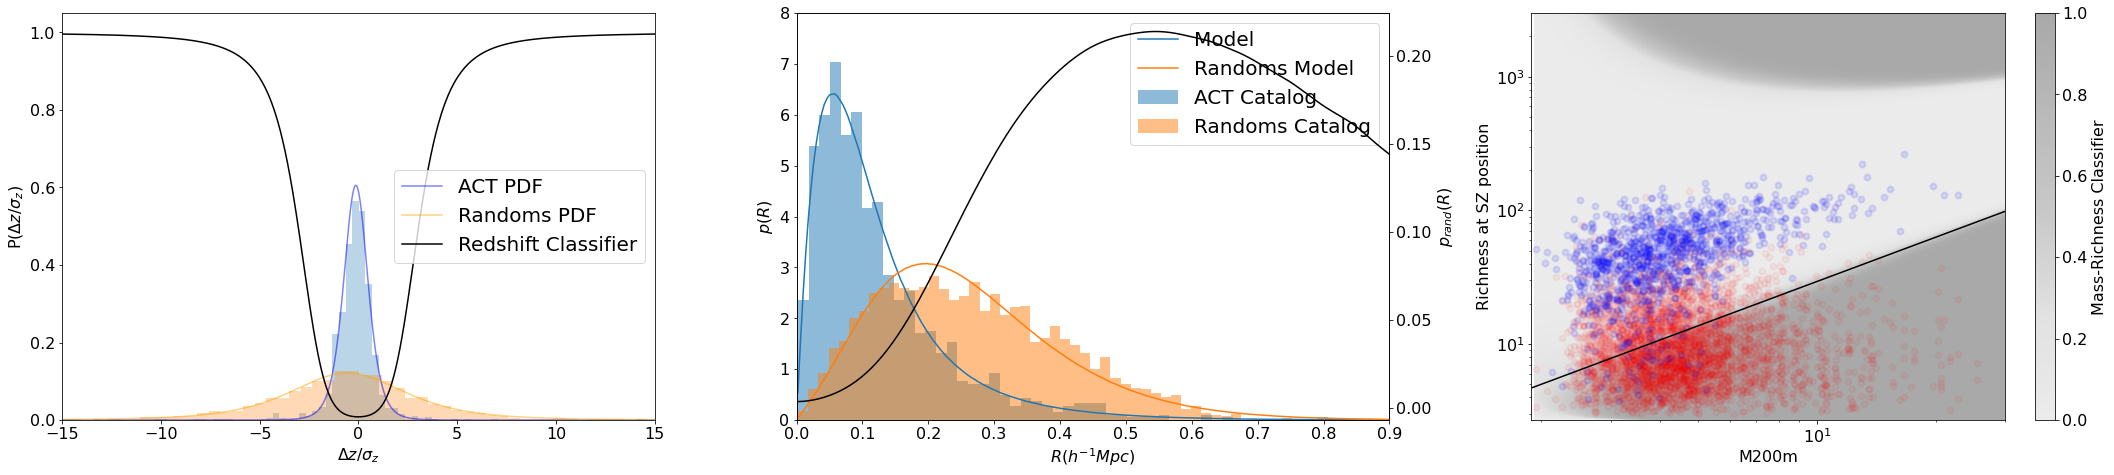

In [123]:
fig,(ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(30,7))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

N=len(all)
count,bins=np.histogram(all['withprior_physical_sep'],bins=50)
center = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0])
ax2.bar(center,count/N/width,width=width,alpha=0.5,label='ACT Catalog')

x=mycenter
alpha=np.array(m.values)[1]
beta=np.array(m.values)[0]
gammafunc = beta**alpha/gamma(alpha)*x**(alpha-1)*np.exp(-beta*x)
#ax2.plot(x, gammafunc,linewidth=2, label='Offset distribution in absence of measurement error')
ax2.plot(mycenter, mymean, label='Model')

bottom=mymean-mystd
top=mymean+mystd
#ax2.fill_between(mycenter,bottom,top,alpha=0.5)

N=len(randoms)
count,bins=np.histogram(randoms['withprior_physical_sep'],bins=50)
center = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0])
ax2.bar(center,count/N/width,width=width,alpha=0.5,label='Randoms Catalog')

x=mycenter
alpha=np.array(n.values)[1]
beta=np.array(n.values)[0]

randgammafunc = beta**alpha/gamma(alpha)*x**(alpha-1)*np.exp(-beta*x)
#ax2.plot(x, gammafunc,linewidth=2, label='Offset distribution in absence of measurement error')
ax2.plot(mycenter, randmean, label='Randoms Model')

bottom=randmean-randstd
top=randmean+randstd
#ax2.fill_between(mycenter,bottom,top,alpha=0.5)

switch=500
randoms_pdf_sigma=np.append(randmean[:switch],randgammafunc[switch:])/fr
all_pdf_sigma=np.append(mymean[:switch],gammafunc[switch:])

odds_sigma=randoms_pdf_sigma/all_pdf_sigma
prob_sigma=odds_sigma/(odds_sigma+1)

# Adding Twin Axes to plot using dataset_2
ax9 = ax2.twinx()
#ax9.plot(mycenter,prob_sigma, color='k', label='Separation Classifier')
switch=300
randoms_pdf_sigma=np.append(randmean[:switch],randgammafunc[switch:])/fr
all_pdf_sigma=np.append(mymean[:switch],gammafunc[switch:])

odds_sigma=randoms_pdf_sigma/all_pdf_sigma
prob_sigma=odds_sigma/(odds_sigma+1)

mask = np.isnan(prob_sigma)
prob_sigma[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), prob_sigma[~mask])

prob_smooth = gaussian_filter1d(prob_sigma, sigma=5)
ax9.plot(mycenter,prob_smooth, color='k', label='Separation Classifier')

ax9.set_ylabel('$p_{rand}(R)$')

#ax1.hist(same['SZ_angular_sep']/np.radians(1.)/deg_err,30,label='With Prior')
#ax1.hist(same_noprior['SZ_angular_sep']/np.radians(1.)/deg_err,30,alpha=0.5, label='No Prior')

ax2.set_xlabel(r'$R (h^{-1} Mpc)$')
ax2.set_ylabel(r'$p(R)$')
ax2.set_ylim([0,8])
ax2.set_xlim([0,0.9])
ax2.legend()

N=len(all)
count,bins=np.histogram((all.zopt-all.redshift)/all.redshiftErr,bins=100)
center = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0])
ax1.bar(center,count/N/width,width=width,alpha=0.3)

Nmix=1

x = np.linspace(-15, 15, 10000)

pdf_fitted = t.pdf(x, loc=allparam[1], scale=allparam[2], df=allparam[0])
ax1.plot(x,pdf_fitted, color='b', alpha=0.5, label='ACT PDF')

N=len(randoms)
count,bins=np.histogram((randoms.zopt-randoms.redshift)/randoms.redshiftErr,bins=100)
center = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0])
ax1.bar(center,count/N/width,width=width,alpha=0.3)

#ax1.plot(x,pdf, color='orange')
samp = (randoms.zopt-randoms.redshift)/randoms.redshiftErr
param = t.fit(samp)

pdf_fitted = t.pdf(x, loc=param[1], scale=param[2], df=param[0])
ax1.plot(x,pdf_fitted, color='orange',alpha=0.5,label='Randoms PDF')

x=np.linspace(-80,80,10000)

all_pdf_z=t.pdf(x, loc=allparam[1], scale=allparam[2], df=allparam[0])
all_pdf_z=t.pdf(x, loc=0, scale=allparam[2], df=allparam[0])


random_pdf_z = t.pdf(x, loc=param[1], scale=param[2], df=param[0])
random_pdf_z = t.pdf(x, loc=0, scale=param[2], df=param[0])
random_pdf_z /= fr

odds_z=random_pdf_z/(all_pdf_z+1e-100)
prob_z=odds_z/(odds_z+1)
prob_z[np.where(np.isinf(odds_z))[0]]=1.0
ax1.plot(x,prob_z,color='k', label='Redshift Classifier')
ax1.set_xlabel(r'$\Delta z/\sigma_z$')
ax1.set_ylabel(r'P($\Delta z/\sigma_z$)')
ax1.set_xlim([-15,15])
ax1.legend()

h = ax3.pcolormesh(xv,np.exp(yv),prob_M,label='Randoms',cmap=grayify_cmap('Wistia'),shading='auto')

ax3.scatter(randoms.M200m,(randoms.lambda_norecenter),linewidth=2, color='r', label='randoms',alpha=0.05)
ax3.scatter(all.M200m,(all.lambda_norecenter),linewidth=2, color='b', label='ACT',alpha=0.1)

x=np.linspace(1.9,30,1000)

A,alpha,s0,B,beta=np.array(mm.values)

model = alpha * np.log(x/_M0) + A
sigma2 = s0 + B*(x/_M0)**beta
y=(model)
#ax3.plot(x,y)

logx=np.log(x)
logfit=0.85+1.1*logx

ax3.plot(x,np.exp(logfit),'k')

clb=plt.colorbar(h, ax=ax3)
#clb.set_label('label', labelpad=-40, y=1.05, rotation=0)
clb.ax.set_ylabel('Mass-Richness Classifier')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylabel('Richness at SZ position')
ax3.set_xlabel('M200m')

plt.tight_layout()

In [124]:
from scipy import interpolate

In [125]:
x=np.linspace(-80,80,10000)
f_z=interpolate.interp1d(x,prob_z)
x=mycenter
f_sigma=interpolate.interp1d(x,prob_sigma)

In [129]:
#The data for the separation pdfs is poorly defined at large r.
#Fortunately, at large 'r' it is very close to just the distribution
#of gas offsets. So, I define this piecewise.

x=mycenter

alpha=np.array(m.values)[1]
beta=np.array(m.values)[0]
gammafunc = beta**alpha/gamma(alpha)*x**(alpha-1)*np.exp(-beta*x)
alpha=np.array(n.values)[1]
beta=np.array(n.values)[0]
randgammafunc = beta**alpha/gamma(alpha)*x**(alpha-1)*np.exp(-beta*x)

switch=500

prob_smooth = gaussian_filter1d(prob_sigma, sigma=5)
randoms_pdf_theta=np.append(randmean[:switch],randgammafunc[switch:])/fr
all_pdf_theta=np.append(mymean[:switch],gammafunc[switch:])

all_pdf_theta=interpolate.interp1d(x,all_pdf_theta)
randoms_pdf_theta=interpolate.interp1d(x,randoms_pdf_theta)

x=np.linspace(-80,80,10000)
y=t.pdf(x, loc=allparam[1], scale=allparam[2], df=allparam[0])
all_pdf_z = interpolate.interp1d(x,y)

y=t.pdf(x, loc=param[1], scale=param[2], df=param[0])
randoms_pdf_z = interpolate.interp1d(x,y/fr)

# Total classifier

We now have all the interpolated functions we require:

all_pdf_M_lnSZ(Mass, Richness) (in 10^14 solar mass) <br>
randoms_pdf_M_lnSZ(Mass, Richness)<br>
...these return the value of the pdf for an input mass and richness

all_pdf_theta(R) (in h^-1 Mpc)<br>
randoms_pdf_theta(R)<br>
...these return the value of the pdf's for an input distance between the mass signal and its optical counterpart

all_pdf_z(z_mass - z_optical / z_mass_err)<br>
randoms_pdf_z<br>
...these return the value of the pdf's for an input redshift difference, in units of the redshift measurement error

In [130]:
#Let's start by opening a fresh copy of the catalogs. You can skip to this line if you've run the code recently.

In [131]:
all=pd.read_pickle('ACT_withrprior_convradialfilter_withzscanprior_nozlambdalikeprior_withneighborcorrection_iteration2.pkl')
all_noprior=pd.read_pickle('ACT_norprior_convradialfilter_withzscanprior_nozlambdalikeprior_withneighborcorrection_iteration2.pkl')

all['deg_err'] = (1.483/all.fixed_SNR-0.012)/60#degrees
all_noprior['deg_err'] = (1.483/all_noprior.fixed_SNR-0.012)/60 #degrees

o = pd.DataFrame(columns = all_noprior.columns)
for i in range(len(all_noprior)):
    o=o.append(all[all.index==all_noprior.index[i]])
all=o

o = pd.DataFrame(columns = all.columns)
for i in range(len(all)):
    o=o.append(all_noprior[all_noprior.index==all.index[i]])

all_noprior=o

all['SZ_angular_sep']=angular_separation(all.RADeg,all.decDeg, all.raopt, all.decopt)
all_noprior['SZ_angular_sep']=angular_separation(all_noprior.RADeg,all_noprior.decDeg, all_noprior.raopt, all_noprior.decopt)

all['pnop_angular_sep']=angular_separation(all.raopt, all.decopt, all_noprior.raopt, all_noprior.decopt)
all_noprior['pnop_angular_sep']=angular_separation(all.raopt, all.decopt, all_noprior.raopt, all_noprior.decopt)

COSMO = FlatLambdaCDM(H0=100, Om0=0.3)
angular_diameter_distances = COSMO.angular_diameter_distance(all.zopt).value #Mpc
all['withprior_physical_sep']=all['SZ_angular_sep']*angular_diameter_distances
all['D_A']=COSMO.angular_diameter_distance(all.zopt).value*np.radians(1.) #Mpc/degree

COSMO = FlatLambdaCDM(H0=100, Om0=0.3)
angular_diameter_distances = COSMO.angular_diameter_distance(all_noprior.zopt).value #Mpc
all_noprior['noprior_physical_sep']=all_noprior['SZ_angular_sep']*angular_diameter_distances
all_noprior['D_A']=COSMO.angular_diameter_distance(all_noprior.zopt).value*np.radians(1.) #Mpc/degree

different=all[all.pnop_angular_sep>1e-5].reset_index(drop=True)
different_noprior=all_noprior[all_noprior.pnop_angular_sep>1e-5].reset_index(drop=True)

names_to_cut = different.name
same=all[~all.name.isin(names_to_cut)]
same_noprior=all_noprior[~all_noprior.name.isin(names_to_cut)]

<ipython-input-2-8e8971527cee>:7: RuntimeWarning: invalid value encountered in arccos
  angular_sep=np.arccos(np.sin(d1)*np.sin(d2)+np.cos(d1)*np.cos(d2)*np.cos(r1-r2))


In [132]:
Deltaz=np.array((all.zopt-all.redshift)/all.redshiftErr)
Deltatheta=np.array(all['withprior_physical_sep'])

In [135]:
#The total pdf is the product of the 3 subspace pdf's.

In [136]:
prob_final=[]
for i in range(len(all)):
    pMlnSZ=all_pdf_M_lnSZ(all['M200m'].iloc[i],np.log(all['lambda_norecenter'].iloc[i]))[0]
    ptheta=all_pdf_theta(Deltatheta[i])
    pz=all_pdf_z(Deltaz[i])
    prob_ACT=pMlnSZ*ptheta*pz

    pMlnSZ=randoms_pdf_M_lnSZ(all['M200m'].iloc[i],np.log(all['lambda_norecenter'].iloc[i]))[0]
    ptheta=randoms_pdf_theta(Deltatheta[i])
    pz=randoms_pdf_z(Deltaz[i])
    prob_randoms=pMlnSZ*ptheta*pz

    odds_final=prob_randoms/prob_ACT
    prob_final=np.append(prob_final,odds_final/(1+odds_final))
prob_final

array([3.15790947e-07, 8.91518523e-04, 1.20002676e-06, ...,
       1.73572439e-03, 4.63513165e-04, 7.64945027e-08])

(0.0, 1.0)

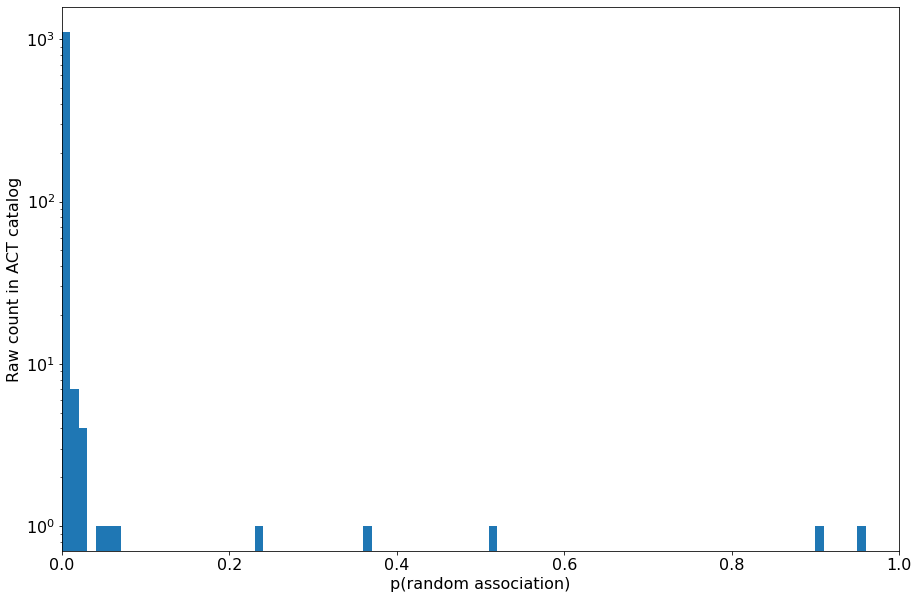

In [137]:
fig,(ax1) = plt.subplots(1, 1,figsize=(15,10))

N=len(all)
nbins=50
count,bins=np.histogram(prob_final,bins=np.linspace(0,1,101))
center = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0])
ax1.bar(center,count,width=width)

ax1.set_xlabel('p(random association)')
ax1.set_ylabel('Raw count in ACT catalog')
ax1.set_yscale('log')
ax1.set_xlim([0,1])

In [138]:
all['prob_rand']=prob_final

In [139]:
#Find the expectation value of the number of outliers

In [140]:
np.sum(all['prob_rand'])

3.4579746543175887

In [141]:
all[all['prob_rand']>0.2].name

296     b'ACT-CL J0047.7-1033'
318     b'ACT-CL J0051.6+0728'
1933    b'ACT-CL J0818.4+0310'
1976    b'ACT-CL J0842.9+0424'
3656    b'ACT-CL J2205.0+0739'
Name: name, dtype: object

In [144]:
#Matches with high probability in the subspaces are probably actual clusters, but are 
#incorrectly centered. So, I define separate probabilities in each space.

In [145]:
prob_theta=[]
for i in range(len(all)):
    pMlnSZ=all_pdf_M_lnSZ(all['M200m'].iloc[i],np.log(all['lambda_norecenter'].iloc[i]))[0]
    ptheta=all_pdf_theta(Deltatheta[i])
    pz=all_pdf_z(Deltaz[i])
    prob_ACT=ptheta

    pMlnSZ=randoms_pdf_M_lnSZ(all['M200m'].iloc[i],np.log(all['lambda_norecenter'].iloc[i]))[0]
    ptheta=randoms_pdf_theta(Deltatheta[i])
    pz=randoms_pdf_z(Deltaz[i])
    prob_randoms=ptheta

    odds_final=prob_randoms/prob_ACT
    prob_theta=np.append(prob_theta,odds_final/(1+odds_final))
prob_theta

array([0.00578279, 0.00590156, 0.00499589, ..., 0.14240619, 0.03911906,
       0.0049552 ])

In [146]:
prob_z=[]
for i in range(len(all)):
    pMlnSZ=all_pdf_M_lnSZ(all['M200m'].iloc[i],np.log(all['lambda_norecenter'].iloc[i]))[0]
    ptheta=all_pdf_theta(Deltatheta[i])
    pz=all_pdf_z(Deltaz[i])
    prob_ACT=pz

    pMlnSZ=randoms_pdf_M_lnSZ(all['M200m'].iloc[i],np.log(all['lambda_norecenter'].iloc[i]))[0]
    ptheta=randoms_pdf_theta(Deltatheta[i])
    pz=randoms_pdf_z(Deltaz[i])
    prob_randoms=pz

    odds_final=prob_randoms/prob_ACT
    prob_z=np.append(prob_z,odds_final/(1+odds_final))
prob_z

array([0.01334172, 0.02111287, 0.01694585, ..., 0.79505742, 0.07212032,
       0.00830058])

In [147]:
prob_MlnSZ=[]
for i in range(len(all)):
    pMlnSZ=all_pdf_M_lnSZ(all['M200m'].iloc[i],np.log(all['lambda_norecenter'].iloc[i]))[0]
    ptheta=all_pdf_theta(Deltatheta[i])
    pz=all_pdf_z(Deltaz[i])
    prob_ACT=pMlnSZ

    pMlnSZ=randoms_pdf_M_lnSZ(all['M200m'].iloc[i],np.log(all['lambda_norecenter'].iloc[i]))[0]
    ptheta=randoms_pdf_theta(Deltatheta[i])
    pz=randoms_pdf_z(Deltaz[i])
    prob_randoms=pMlnSZ

    odds_final=prob_randoms/prob_ACT
    prob_MlnSZ=np.append(prob_MlnSZ,odds_final/(1+odds_final))
prob_MlnSZ

array([0.00399906, 0.87451255, 0.01367532, ..., 0.00269185, 0.12781638,
       0.00183184])

In [148]:
all['prob_theta']=prob_theta
all['prob_z']=prob_z
all['prob_MlnSZ']=prob_MlnSZ

all_noprior['prob_theta']=prob_theta
all_noprior['prob_z']=prob_z
all_noprior['prob_MlnSZ']=prob_MlnSZ
all_noprior['prob_rand']=prob_final

In [153]:
#Drop the outliers and save them. You may wish to re-iterate the fits with the new, cleaned catalog.

In [154]:
final_noprior=all_noprior.drop(all_noprior[all_noprior.prob_rand>0.2].index)
final=all.drop(all[all.prob_rand>0.2].index)

In [155]:
final.to_pickle('final.pkl')
final_noprior.to_pickle('final_noprior.pkl')

In [156]:
#These are the final output catalogs with probabilities attached

In [157]:
all.to_pickle('final_ACT_cats_with_p_rand.pkl')
all_noprior.to_pickle('final_ACT_cats_with_p_rand_noprior.pkl')